<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.975 · Deep Learning</p>
<p style="margin: 0; text-align:right;">2021-2 · Màster universitari en Ciència de dades (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# Pràctica: Glaucoma

## Secció 1. Anàlisi Exploratòria de les dades (1,5 punts)
Segons l'article, el conjunt de dades està format per 1707 imatges de 224x224 píxels i repartides en 10 folds. El primer pas serà doncs obtenir el dataset per i comprovar que tenim les dades esperades.

Addicionalment, ens plantegem les següents preguntes sobre el dataset:

* Quin tipus de cross validation tenim?
* Estan estratificats els k-folds


### Generació del dataset
Carreguem les llibreries i llegim les imatges

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import os
import matplotlib.pyplot as plt
import cv2
from random import randint 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import timeit
from sklearn.utils import shuffle
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score
import tensorflow_addons as tfa
import seaborn as sn
from keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime
from keras.models import load_model


# variable global d'entorn de valid
localEnv = False
deltaZero = 0.0000001
if (localEnv):
    deltaZero = 0.0000001 # Avoid divide by zero on local mode

# Folder execució
execFolder = "EX_%s" % datetime.today().strftime('%Y%m%d_%H%M%S')

# Flag dels models ha generar
flags_gridsearch = [False, True, True, False, False]
flags_model = [False, True, True, False, False]

# verbose fit
verboseFit = 4


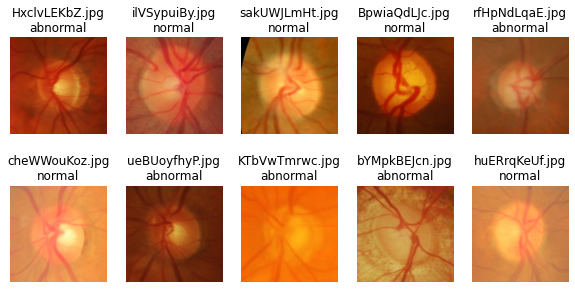

In [2]:
# Imatges
images = []
filenames = []
classes = []

# Dataset
data_aux = []

# Recorrem totes les imatges
for dirname, _, dirfilenames in os.walk('/kaggle/input/practica-dl-uoc-2022'):
    dirname = dirname.replace("\\","/")
    for filename in dirfilenames:
        folders = dirname.split(sep="/")
        
        # Generem un diccionari amb les imatges pre evitar llegir-les cada vegada
        if (filename not in filenames):
            # load the image with load_img
            #img = load_img(dirname+"/"+filename)
            
            # load the image with cv2 (color)
            img = cv2.cvtColor(cv2.imread(dirname+"/"+filename, -1), cv2.COLOR_BGR2RGB)
            
            filenames.append(filename)
            images.append(img)
            classes.append(folders[len(folders)-1])
        
        

        data_aux.append(
                        {
                            'image':filename,
                            'fold': folders[len(folders)-3],
                            'dataset': folders[len(folders)-2],
                            'class': folders[len(folders)-1]
                        }
                    )

df_data = pd.DataFrame(data_aux)
images = np.array(images)
classes = np.array(classes)
filenames = np.array(filenames)
dict_images = dict(zip(filenames, images))

# Mostrem 10 imatges aleatòries
sample = [(randint(1, len(images))) for i in range(10)]
fig, axis = plt.subplots(2, 5, figsize=(10,5))
for i, (X, ax, y) in enumerate(zip(images, axis.reshape(-1), filenames)):
    img = images[sample[i]]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(filenames[sample[i]]+"\n"+classes[sample[i]])


In [3]:
# Anàlisi del conjunt de dades descarregat
#Shapes
print("Dimensions de cada imatge (%s)" % (','.join(str(x) for x in img.shape)))
print("Número d'imatges diferents (%s)" % (','.join(str(x) for x in filenames.shape)))
print("Imatges usades en la validació creuada (%s)" % (','.join(str(x) for x in df_data.shape)))

Dimensions de cada imatge (224,224,3)
Número d'imatges diferents (1707)
Imatges usades en la validació creuada (17070,4)


A partir de les dimensions de les dades deduïm que cada fold conté totes les imatges de manera que per l'anàlisi exploratori de les dades carregarem només les dades del Fold0.

#### Revisió dels folds
A partir de l'estructura de directoris hem obtingut la classe, el fold al que pertany i a quin conjunt de dades pertany la imatge (train, test, valid) dins del fold. Comprovem com es distribueixen les dades per cada fold.

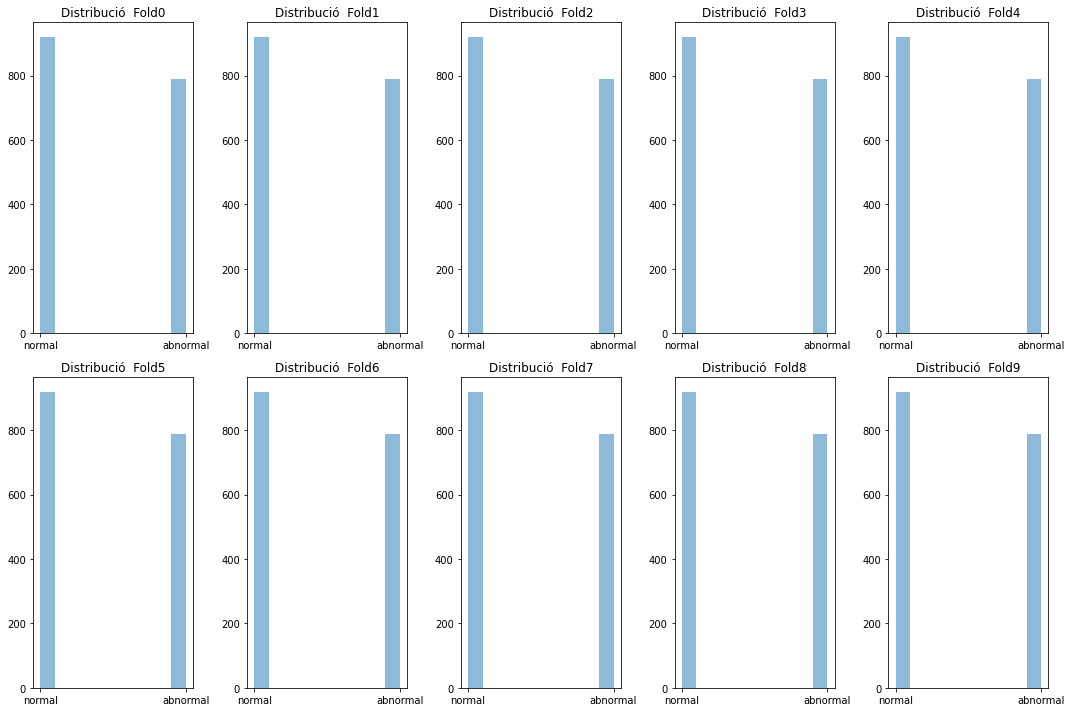

In [4]:
df_data = pd.DataFrame(data_aux)

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15,10))
plot_num = 1
for i in range(10):
    fold = ("Fold%d") % i
    data_i = df_data[df_data.fold == fold]
    plt.subplot(2,5, plot_num)
    plt.title(("Distribució  %s") % fold)
    plt.hist(data_i["class"],alpha=0.5, label="class")
    plot_num += 1   

plt.tight_layout()

Cada fold té una distribució de classes (normal i abnormal) igual de manera que sembla que sí estan estratificats. Fem el al mateix per als datasets per descartar que hi hagi folds amb més o menys dades per a test a validació.

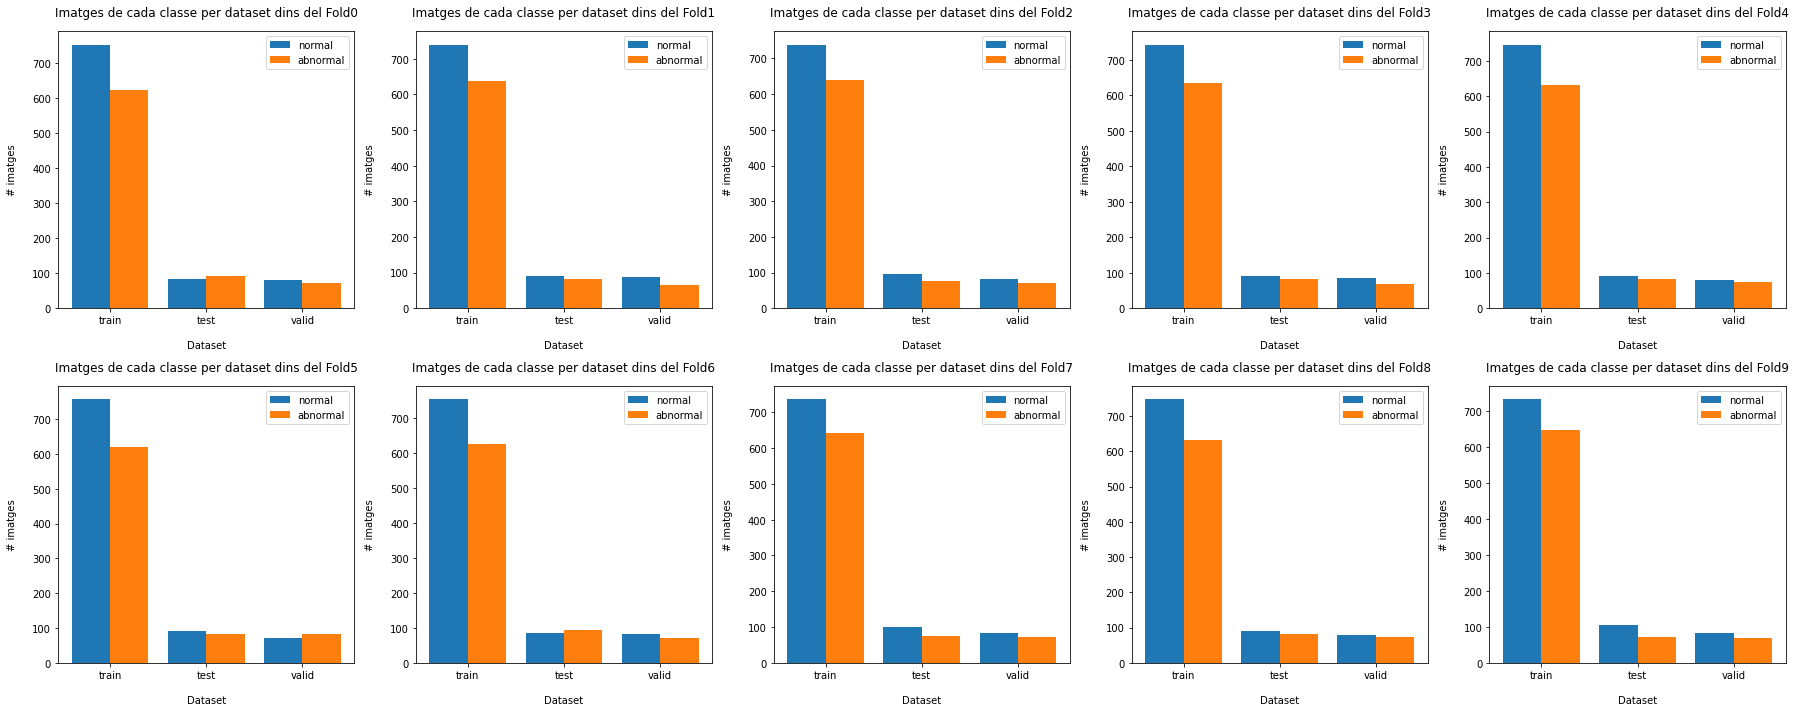

In [5]:
# Agreguem les dades per pintar les barres
grouped_data = df_data.groupby(
    ['fold', 'dataset','class']
).size().sort_values(ascending=False).reset_index(name='count') 

# Pintem el gràfic
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(25,10))

i = 0
for n in range(2):
    for m in range(5):
        # Tractem cada fold
        fold = ("Fold%d") % i
        grouped_data_i = grouped_data[grouped_data.fold == fold]

        ax=axs[n,m]
        x = np.arange(len(grouped_data_i.dataset.unique()))
        bar_width = 0.4
        b1 = ax.bar(x, grouped_data_i.loc[grouped_data_i['class'] == 'normal', 'count'],
                    width=bar_width, label = "normal")
        b2 = ax.bar(x + bar_width, grouped_data_i.loc[grouped_data_i['class'] == 'abnormal', 'count'],
                    width=bar_width, label = "abnormal")

        # Fix the x-axes.
        ax.set_xticks(x + bar_width / 2)
        ax.set_xticklabels(grouped_data_i.dataset.unique())
        ax.legend()

        # Add axis and chart labels.
        ax.set_xlabel('Dataset', labelpad=15)
        ax.set_ylabel('# imatges', labelpad=15)
        ax.set_title('Imatges de cada classe per dataset dins del %s' % fold, pad=15)
        i += 1   

plt.tight_layout()


Observem que tots els folds tenen la mateixa distribució de casos i mides semblants per a cada dataset (train, test, valid) i classe (normal, abnormal). Podem dir que no tenim folds amb biaix. Ens queda per comprovar com s'han fet els folds.

Per acabar mirem si les dades estan repartides de forma equitativa. És a dir, quina estatègia de repartició hi ha al darrera. Per a una estratègia de K-fold cross validation hom esperaria que totes les dades es fessin servir per entrenar i testejar el model i que el conjunt de validació fos sempre el mateix ja que haurien de ser dades que no s'hagin usat mai durant la generació del model (ni entrenament, ni test)<sup>1</sup>

Per tant, esperaríem que les dades de validació sempre fossin les mateixes i la resta es dividissin en 10 grups amb la mateixa distribució de classes on cada grup es fes servir a 9 folds per a entrenament i 1 cop per a test.

Veiem a la taula següent com això no és així i no som capaços d'identificar grups de tamany similar. Sobta veure que hi ha moltes dades que només s'han fet servir per a entrenar i no per a validar o testejar (Grups 8 i 9).

<div style="font-size: 12px;">

| Id Grup	|class	|Fold0.dataset	|Fold1.dataset	|Fold2.dataset	|Fold3.dataset	|Fold4.dataset	|Fold5.dataset	|Fold6.dataset	|Fold7.dataset	|Fold8.dataset	|Fold9.dataset	|Count	|
|---	|---	|---	|---	|---	|---	|---	|---	|---	|---	|---	|---	|---	|
|Grup1	|normal	|test	|test	|test	|test	|test	|test	|test	|test	|test	|test	|5	|
|Grup2	|abnormal	|test	|train	|train	|train	|train	|train	|train	|train	|train	|train	|77	|
|Grup3	|normal	|test	|train	|train	|train	|train	|train	|train	|train	|train	|train	|76	|
|Grup4	|abnormal	|test	|valid	|valid	|valid	|valid	|valid	|valid	|valid	|valid	|valid	|4	|
|Grup5	|normal	|test	|valid	|valid	|valid	|valid	|valid	|valid	|valid	|valid	|valid	|1	|
|Grup6	|abnormal	|train	|test	|test	|test	|test	|test	|test	|test	|test	|test	|70	|
|Grup7	|normal	|train	|test	|test	|test	|test	|test	|test	|test	|test	|test	|77	|
|Grup8	|abnormal	|train	|train	|train	|train	|train	|train	|train	|train	|train	|train	|499	|
|Grup9	|normal	|train	|train	|train	|train	|train	|train	|train	|train	|train	|train	|600	|
|Grup10	|abnormal	|train	|valid	|valid	|valid	|valid	|valid	|valid	|valid	|valid	|valid	|56	|
|Grup11	|normal	|train	|valid	|valid	|valid	|valid	|valid	|valid	|valid	|valid	|valid	|77	|
|Grup12	|abnormal	|valid	|test	|test	|test	|test	|test	|test	|test	|test	|test	|2	|
|Grup13	|normal	|valid	|test	|test	|test	|test	|test	|test	|test	|test	|test	|9	|
|Grup14	|abnormal	|valid	|train	|train	|train	|train	|train	|train	|train	|train	|train	|63	|
|Grup15	|normal	|valid	|train	|train	|train	|train	|train	|train	|train	|train	|train	|64	|
|Grup16	|abnormal	|valid	|valid	|valid	|valid	|valid	|valid	|valid	|valid	|valid	|valid	|6	|
|Grup17	|normal	|valid	|valid	|valid	|valid	|valid	|valid	|valid	|valid	|valid	|valid	|10	|
</div>
<p><sup>1</sup> Gironés Roig, Jordi; Casas Roma, Jordi; Minguillón Alfonso, Julià; Cahiluelas Quiles, Ramon. Minería de Datos. Modelos y Algoritmos. Barcelona: Editorial UOC, 2017. ISBN: 978-84-9116-904-8 [consulta: 28 de maig de 2022]

## Secció 2. Entrenament d’una xarxa neuronal sobre una única partició (4 punts)
A continuació entrenarem 5 models diferents a partir de les dades anteriors sobre la partició Fold0 la qual ja hem comprovat a l’apartat anterior que tenia una distribució d’imatges semblant al conjunt de dades.
Els 3 primers models es basaran en basat en EfficientNet  B0 preentrenats amb els pesos d'ImageNet. Per a generar el model farem servir la llibreria Keras  .
Donat que el volum de dades és relativament baix i la similitud de les imatges molt gran ens decantarem per aprofitar les primeres capes d’EfficientNet congelant-les. D’aquesta manera aprofitarem la potència d’EfficientNet per extreure característiques de les imatges que posteriorment el nostre model aprofitarà per aprendre i classificar les imatges del nostre model.

Per als models 4 i 5 optarem també per EfficientNet B1 i B2 respectivament. D'aquesta manera podrem comparar el rendiment d'arquitectures més complexes.

Per als models 1, 4 i 5 farem una cerca d'hiperparàmetres i salvarem el model a disc per a poder-los recuperar més endavant.

Els models 2 i 3 seran un ajutament fi del model 1 de manera que els construirem a partir del model salvat a disc prèviament.


### Model 1
Model basat en EfficientNet B0, preentrenat amb els pesos d'Imagenet, al qual se substitueix la seva capa de classificació per: una capa de GlobalAveragePolling2D, una capa de BatchNormalization, una capa de dropout amb probabilitat del 20%, i finalment una capa fully connected.

Abans generarem una funció per a obtenir els jocs de dades per a entrenar a partir del fold.

In [6]:
def getData (fold):
    # Obtenim les dades del fold
    df_fold_data = df_data[df_data.fold==fold]

    # Recorrem les dades i generem els diferents arrays
    X_train_fold = []
    X_test_fold = []
    X_valid_fold = []
    y_train_fold = []
    y_test_fold = []
    y_valid_fold = []

    for index, row in df_fold_data.iterrows():
        # Convertim l'array de string en nombre.
        #  0 -> Normal
        #  1 -> Abnormal
        y = 0 if row["class"] == 'normal' else 1 

        if row['dataset']=="train":
            # Add to train
            X_train_fold.append(dict_images[row["image"]])
            y_train_fold.append(y)

        elif row['dataset']=="test":
            # Add to test
            X_test_fold.append(dict_images[row["image"]])
            y_test_fold.append(y)

        else:
            # Add to validate
            X_valid_fold.append(dict_images[row["image"]])
            y_valid_fold.append(y)

    # Desendrecem les dades
    p_train = np.random.permutation(len(X_train_fold))
    p_test = np.random.permutation(len(X_test_fold))
    p_valid = np.random.permutation(len(X_valid_fold))
    
    # Retornem els resultats
    return  np.array(X_train_fold)[p_train], np.array(y_train_fold)[p_train], np.array(X_test_fold)[p_test], np.array(y_test_fold)[p_test], np.array(X_valid_fold)[p_valid], np.array(y_valid_fold)[p_valid]

fold = "Fold0"
X_train, y_train, X_test, y_test, X_valid, y_valid = getData(fold)

També una funció per veure les mètriques dels models

In [7]:
# Plot del training loss i l'accuracy
def plot_prediction(history, description=""):
    #Plots 
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,5))
    
    # F1
    zipped_train = zip(history.history['precision'], history.history['recall'])
    f1_score_train = [2 * x * y /(x + y + deltaZero) for (x, y) in zipped_train]

    zipped_test = zip(history.history['val_precision'], history.history['val_recall'])
    f1_score_test = [2 * x * y /(x + y + deltaZero) for (x, y) in zipped_test]
    
    plt.subplot(1,5,1)
    plt.plot(f1_score_train)
    plt.plot(f1_score_test)
    plt.title('model F1-score %s' % description)
    plt.ylabel('F1-score')
    plt.xlabel('epoch')
    ax = plt.gca()
    ax.set_ylim(bottom=0)
    plt.legend(['train', 'test'], loc='lower right')
    
    # Accuracy
    plt.subplot(1,5,2)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('model binary_accuracy %s' % description)
    plt.ylabel('binary_accuracy')
    plt.xlabel('epoch')
    ax = plt.gca()
    ax.set_ylim(bottom=0)
    plt.legend(['train', 'test'], loc='lower right')

    # Loss
    plt.subplot(1,5,3)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss %s' % description)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower left')
    ax = plt.gca()
    ax.set_ylim(bottom=0)

    # Precision
    plt.subplot(1,5,4)
    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.title('model precision %s' % description)
    plt.ylabel('precision')
    plt.xlabel('epoch')
    ax = plt.gca()
    ax.set_ylim(bottom=0)
    plt.legend(['train', 'test'], loc='lower right')
    
    # Recall
    plt.subplot(1,5,5)
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_recall'])
    plt.title('model recall %s' % description)
    plt.ylabel('recall')
    plt.xlabel('epoch')
    ax = plt.gca()
    ax.set_ylim(bottom=0)
    plt.legend(['train', 'test'], loc='lower right')

    
    plt.tight_layout()


Definim les mètriques que recollirem per a tots els models. La F1-score pot ser calcualda a partir de la precision i recall de manera que no l'afegim.

In [8]:
metrics = [tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.BinaryAccuracy(name="binary_accuracy")]
patience=10

2022-06-07 06:06:07.640800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 06:06:07.797589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 06:06:07.798406: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 06:06:07.799576: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

A la primera configuració s'entrena el model congelant totes les capes, excepte les que s'han afegit al final (model 1).

Durant les proves veiem que el Model 1 de seguida arriba al f1-score alt amb un patience de 5. Decidim pujar-lo a 10 ja que aturar l'entrenament al cap de menys de 10 èpoques ens sembla que podem perdre algun model millor.

Passem ara a entrenar el millor model amb cross validation usant les particions proporcionades.

Per a fer-ho simplement repetirem el que hem fet a l'apartat anterior però amb les imatges dels altres folds i carregant el millor model de disc.


In [9]:
def getModelDisk(filepath, fold, batch_size, epochs, learning_rate):
    # Carreguem el model de disk
    bestmodel = load_model(filepath)

    # Carreguem les dades
    #print("Carregant dades %s" % fold)
    X_train, y_train, X_test, y_test, X_valid, y_valid = getData(fold)
    #print("Dades carregades de %s. Train: %s - Test: %s - Valid: %s" % (fold, X_train.shape, X_test.shape, X_valid.shape))
    

    # Ús d'Adam com a optimitzador
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compilem el model
    #print("Compilar model")
    bestmodel.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=metrics, run_eagerly=True)
    #print("Model compilat")
        
    

    #Callback per salvar el millor model
    filepath = '/kaggle/working/%s/BEST/%s_ModelBest_Epoch-{epoch:02d}_Loss-{val_loss:.2f}_Batch-%d_LR_%.4f.hdf5' % (execFolder, datetime.today().strftime('%Y%m%d%H%M%S'), batch_size, learning_rate)
    checkpoint = ModelCheckpoint(filepath=filepath, 
                                monitor='val_loss',
                                verbose=verboseFit, 
                                save_best_only=True,
                                mode='min')
    
    # Callback per parar si no millorem en 5 èpoques
    earlystopping = EarlyStopping(monitor='val_loss', patience=patience)
    
    callbacks = [earlystopping,checkpoint]

    # Menys dades per l'entorn local
    X_train_aux = X_train
    y_train_aux = y_train
    X_valid_aux = X_valid
    y_valid_aux = y_valid

    
    if (localEnv):
        X_train_aux = X_train[:n]
        y_train_aux = y_train[:n]
        X_valid_aux = X_valid[:n]
        y_valid_aux = y_valid[:n]
        
    # Entrenem el model
    #print("Entrenar model")
    history = bestmodel.fit(X_train_aux, y_train_aux, validation_data=(X_valid_aux, y_valid_aux), epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=verboseFit) # Remove
    #print("Model entrenat")
    
    # Calculem f1-score sobre les dades de validació 
    loss, precision, recall, accuracy = bestmodel.evaluate(X_valid, y_valid)
    f1_valid = 2 * precision * recall /(precision + recall + deltaZero)

    # Calculem f1-score sobre les dades de test 
    loss, precision, recall, accuracy = bestmodel.evaluate(X_test, y_test)
    f1_test = 2 * precision * recall /(precision + recall + deltaZero)

    return history, f1_valid, f1_test
    

Processant Fold0


2022-06-07 06:06:13.437207: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/75


2022-06-07 06:06:14.367224: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005



Epoch 00001: val_loss improved from inf to 0.52340, saving model to /kaggle/working/EX_20220607_060550/BEST/20220607060613_ModelBest_Epoch-01_Loss-0.52_Batch-8_LR_0.0001.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/75

Epoch 00002: val_loss improved from 0.52340 to 0.51314, saving model to /kaggle/working/EX_20220607_060550/BEST/20220607060613_ModelBest_Epoch-02_Loss-0.51_Batch-8_LR_0.0001.hdf5
Epoch 3/75

Epoch 00003: val_loss improved from 0.51314 to 0.50622, saving model to /kaggle/working/EX_20220607_060550/BEST/20220607060613_ModelBest_Epoch-03_Loss-0.51_Batch-8_LR_0.0001.hdf5
Epoch 4/75

Epoch 00004: val_loss improved from 0.50622 to 0.50147, saving model to /kaggle/working/EX_20220607_060550/BEST/20220607060613_ModelBest_Epoch-04_Loss-0.50_Batch-8_LR_0.0001.hdf5
Epoch 5/75

Epoch 00005: val_loss improved from 0.50147 to 0.49414, saving model to /kaggle/working/EX_20220607_060550/BEST/20220607060613_ModelBest_Epoch-05_Loss-0.49_Batch-8_LR_0.0001.hdf5
Epoch 6/75

Epoch 00006: val_loss improved from 0.49414 to 0.48986, saving model to /kaggle/working/EX_20220607_060550/BEST/20220607060613_ModelBest_Epoch-06_Loss-0.49_Batch-8_LR_0.0001.hdf5
Epoch 7/75

Epoch 00007: val_loss improved fr

,fold,f1_valid,f1_test
0,Fold0,0.710744,0.775000
1,Fold1,0.800000,0.827160
2,Fold2,0.835821,0.733813
3,Fold3,0.796992,0.810811
4,Fold4,0.779412,0.819876
5,Fold5,0.834437,0.779221
6,Fold6,0.796875,0.780488
7,Fold7,0.811594,0.820895
8,Fold8,0.785185,0.789474
9,Fold9,0.794326,0.740741


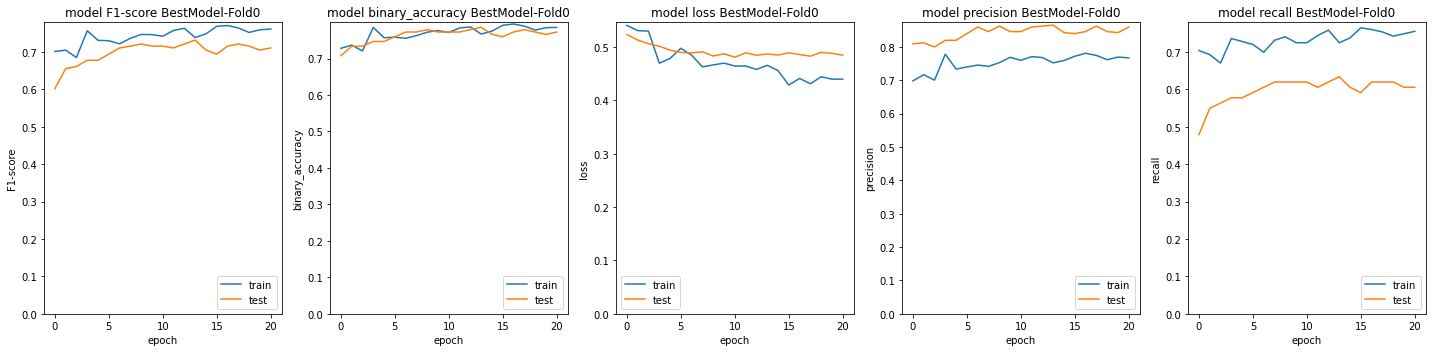

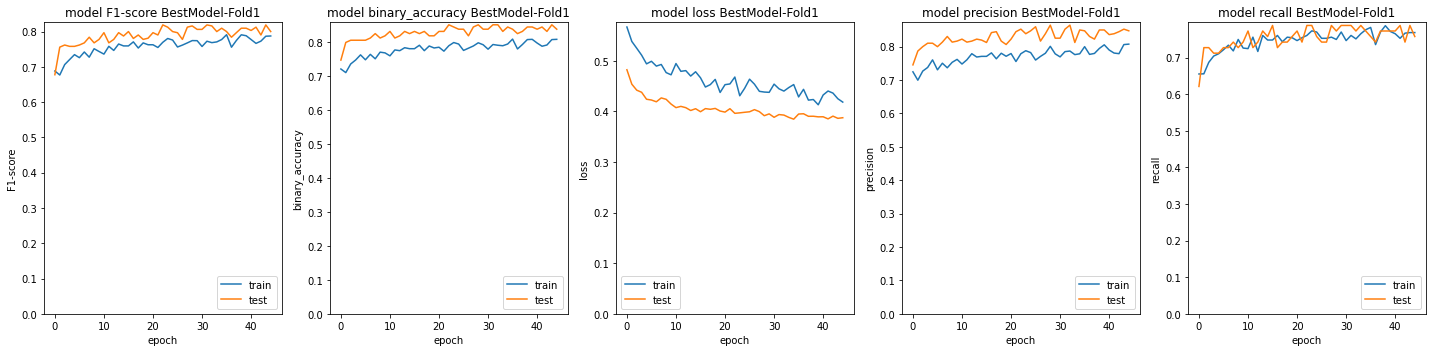

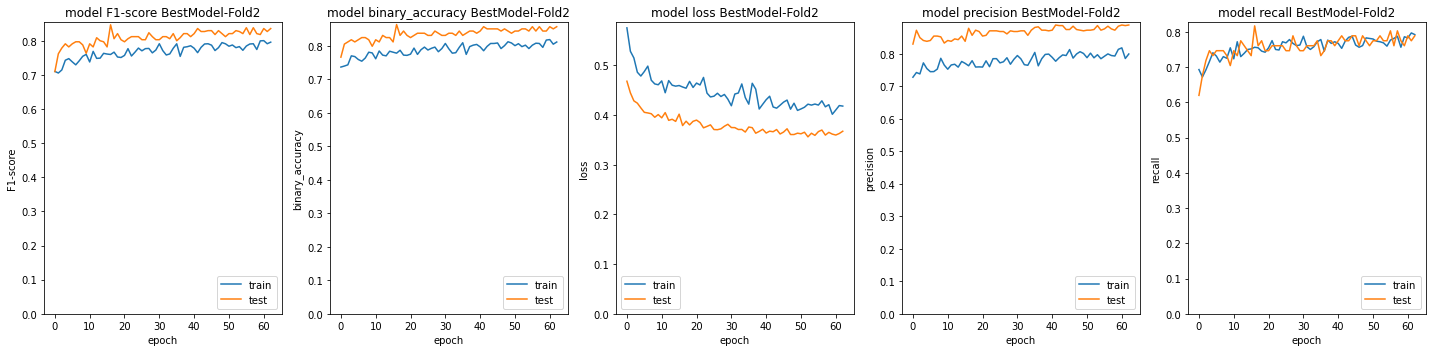

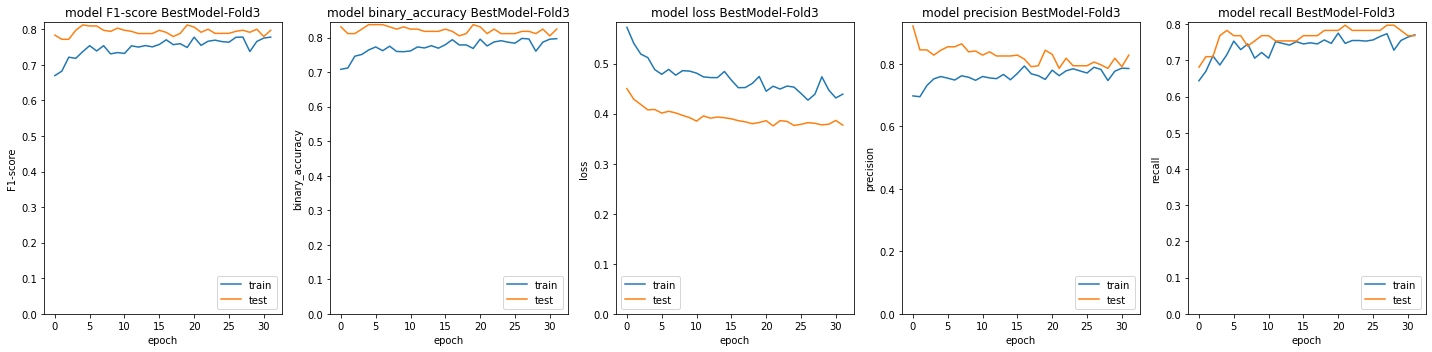

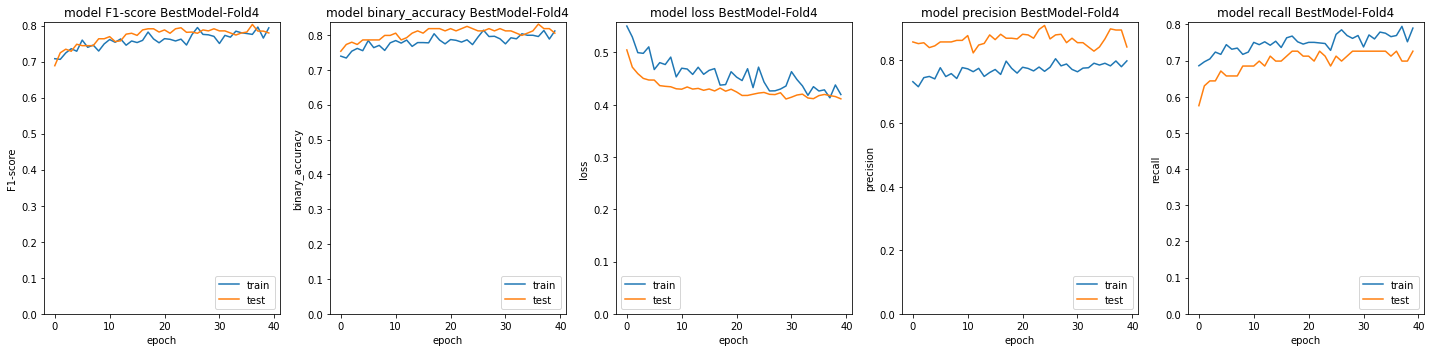

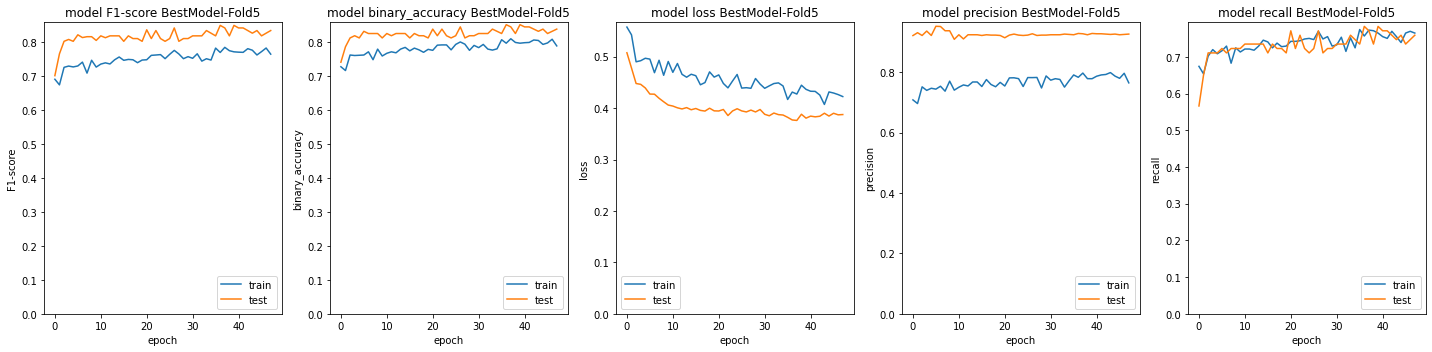

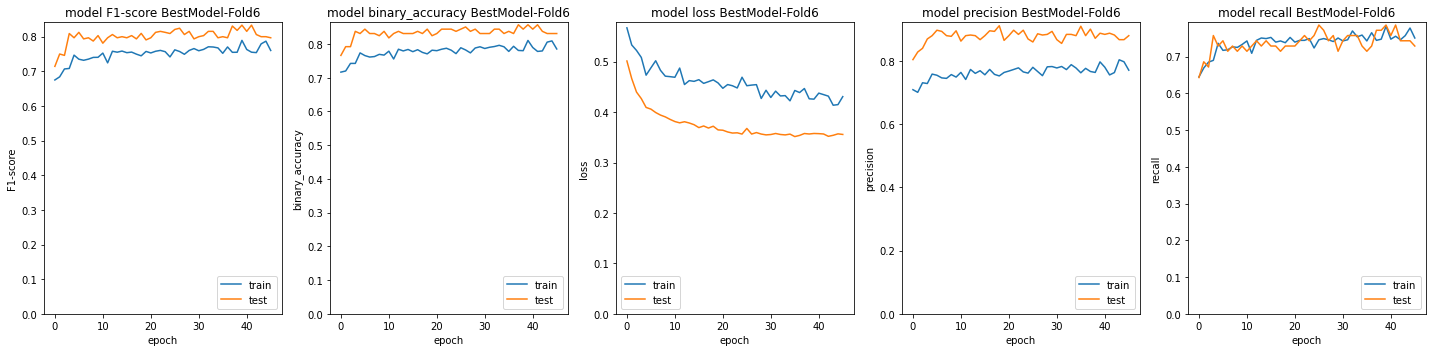

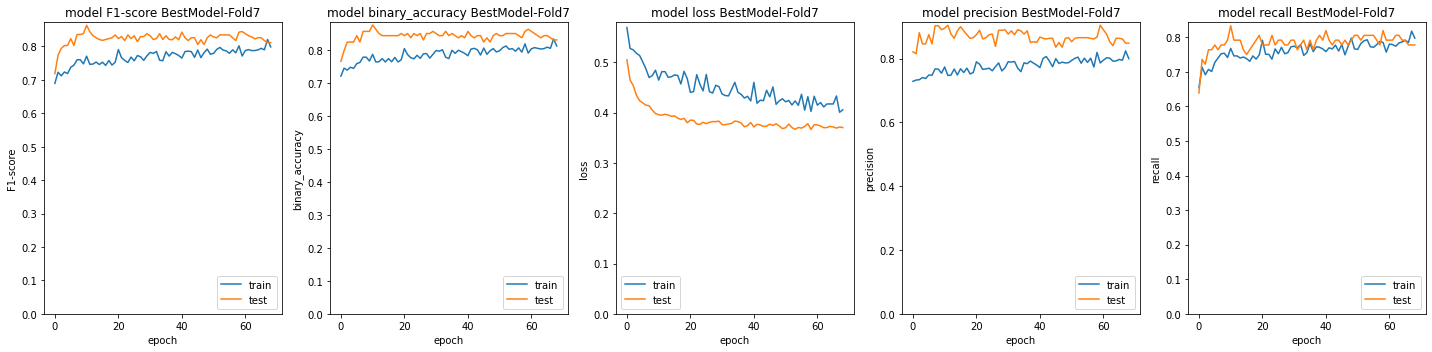

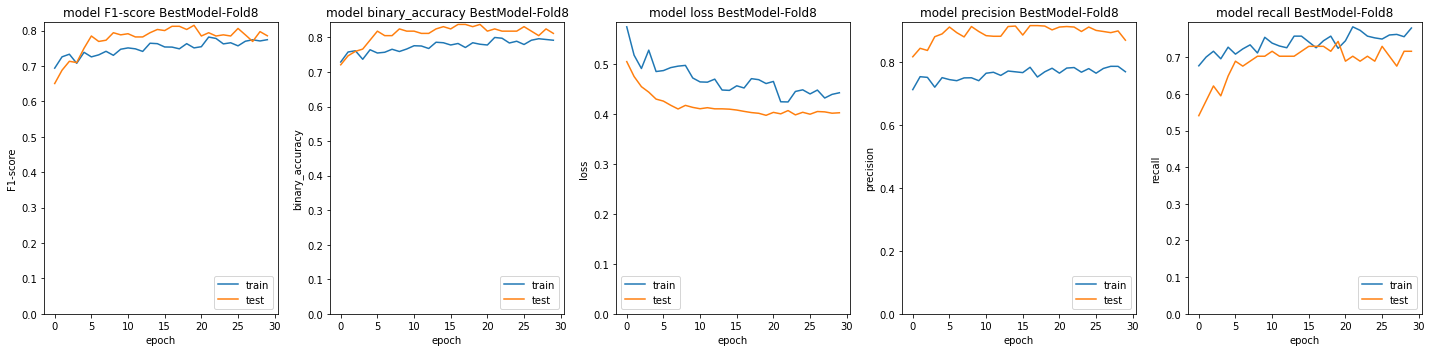

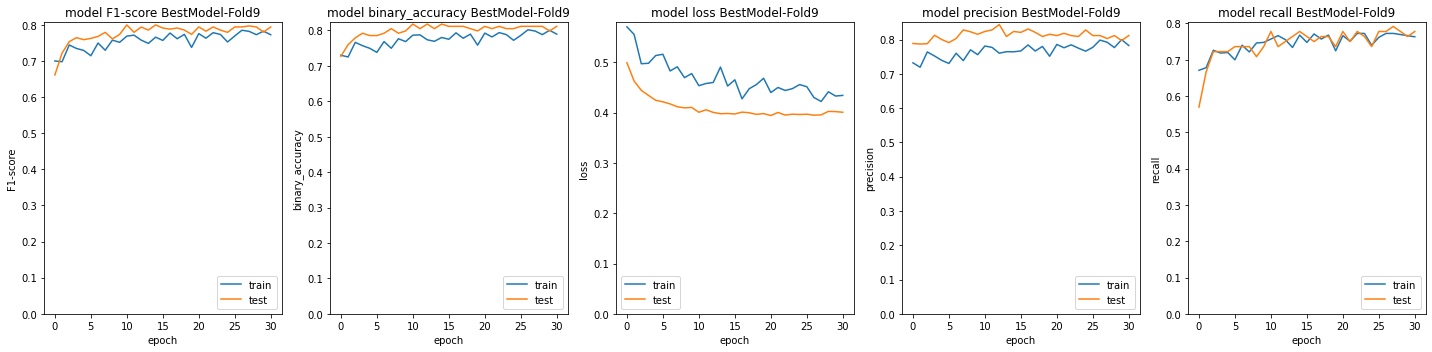

In [10]:
# Carreguem el millor model
filepath_bestmodel = "/kaggle/input/Models/20220601105039_Model1_Epoch-47_Loss-0.40_Batch-8_Rate-0.0001.hdf5"

batch_size = 8
learning_rate = 0.0001
epochs = 75
if (localEnv):
    epochs = 2

results_bestmodel=[]

k=10
if (localEnv):
        k=3

for i in range(k):
    # Carreguem el millor model, el compilem, l'executem i avaluem per a cada fold
    fold = "Fold%s" % i
    print("Processant %s" % (fold)) 
    
    history_model, f1_valid, f1_test = getModelDisk(filepath_bestmodel, fold, batch_size, epochs, learning_rate)
    results_bestmodel.append(
                    {
                        'fold': fold,
                        'f1_valid': f1_valid,
                        'f1_test': f1_test,
                    }
    )
    
    # Mostrem les mètriques    
    plot_prediction(history_model, "BestModel-%s" % (fold))
    print("")

# Mostrem els resultats
display(pd.DataFrame(results_bestmodel))